<a href="https://colab.research.google.com/github/Chanu23UOM/Pneumonia_detection_with_ResNet50/blob/main/GMora_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection from Chest X-rays using Deep Learning
## Team GMora - BioFusion Hackathon 2026

---

# 1. Problem Definition

## Clinical and Healthcare Relevance

Pneumonia is one of the leading causes of mortality worldwide, particularly among children and the elderly. According to the World Health Organization:
- **450 million cases** of pneumonia occur annually
- Causes approximately **15% of all deaths** in children under 5 years old
- Accounts for **4 million deaths globally** each year
- Early detection is critical for effective treatment and reducing mortality

## The Problem We're Addressing

**Diagnostic Challenges:**
- Shortage of radiologists, especially in developing countries and rural areas
- Time-intensive manual diagnosis leading to delays in treatment
- High variability in diagnostic accuracy among general practitioners
- Limited access to expert radiologists in low-resource settings

**What We're Predicting:**
This project develops an automated deep learning model to classify chest X-ray images as either:
- **NORMAL**: Healthy lungs with no signs of pneumonia
- **PNEUMONIA**: Presence of pneumonia infection

The model serves as a decision support tool for healthcare professionals, enabling:
- Rapid pre-screening of chest X-rays
- Prioritization of high-risk cases for radiologist review
- Accessible diagnostic support in areas with limited medical expertise

# 2. Dataset Documentation

## Dataset Citation and Source

**Dataset:**  Chest X-Ray Images (Pneumonia)  
**Source:**   Kaggle - Paul Mooney  
**URL:**      https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia  
**Original Source:** Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018). Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification. Mendeley Data, v2.

**Description:** The dataset contains 5,863 chest X-ray images (JPEG) organized into 3 folders (train, test, val) with 2 categories (Pneumonia/Normal). Chest X-ray images were selected from retrospective cohorts of pediatric patients aged 1-5 years from Guangzhou Women and Children's Medical Center, Guangzhou.

# 3. Evaluation Strategy: Clinical Alignment

In the context of pneumonia screening, standard accuracy is an insufficient metric due to the high cost of missed diagnoses. Therefore, we prioritize Sensitivity as our primary performance metric.

## Objective
Minimize **False Negatives** to ensure potential pneumonia cases are not overlooked.

## Reporting
We explicitly report:
- Class-wise Precision and Recall
- Confusion Matrix

This provides a transparent view of the model's safety profile and bias, ensuring clinical reliability.

# 4. Required Python Packages

The following packages are required to run this notebook. Pinned versions ensure reproducibility.

```
torch 2.0.0
torchvision 0.15.0
numpy 1.24.0
pandas 2.0.0
matplotlib 3.7.0
seaborn 0.12.0
Pillow 9.5.0
scikit-learn 1.3.0
tqdm 4.65.0
scipy 1.10.0
kagglehub 0.2.0
```

In [33]:
#requirements.txt
requirements = """torch>=2.0.0
torchvision>=0.15.0
numpy>=1.24.0
pandas>=2.0.0
matplotlib>=3.7.0
seaborn>=0.12.0
Pillow>=9.5.0
scikit-learn>=1.3.0
tqdm>=4.65.0
scipy>=1.10.0
kagglehub>=0.2.0
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements)

print("requirements.txt created successfully!")

requirements.txt created successfully!


In [34]:
!pip install -q kagglehub

In [35]:
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
print('Libraries imported!')
print(f'PyTorch: {torch.__version__}')
print(f'CUDA Available: {torch.cuda.is_available()}')

Libraries imported!
PyTorch: 2.9.0+cu126
CUDA Available: True


# 5. Reproducibility Setup
In order to ensure consistent results we implement seed 42 Reproducibility setup.

In [36]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f'Random seed set to: {SEED}')

Random seed set to: 42


# 6. Downloading the Dataset

In [38]:
path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')
print('Dataset path:', path)
dataset_path = os.path.join(path, 'chest_xray')

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Dataset path: /kaggle/input/chest-xray-pneumonia


# 7. Analyzing Dataset Distribution

In [39]:
def count_images(base_path):
    counts = {}
    for split in ['train', 'test', 'val']:
        split_path = os.path.join(base_path, split)
        counts[split] = {}
        for category in ['NORMAL', 'PNEUMONIA']:
            cat_path = os.path.join(split_path, category)
            if os.path.exists(cat_path):
                counts[split][category] = len([f for f in os.listdir(cat_path) if f.endswith(('.jpeg', '.jpg'))])
    return counts

image_counts = count_images(dataset_path)
for split in ['train', 'val', 'test']:
    print(f"{split.upper()}: NORMAL={image_counts[split]['NORMAL']}, PNEUMONIA={image_counts[split]['PNEUMONIA']}")

TRAIN: NORMAL=1341, PNEUMONIA=3875
VAL: NORMAL=8, PNEUMONIA=8
TEST: NORMAL=234, PNEUMONIA=390


# 8. Visualizing Samples

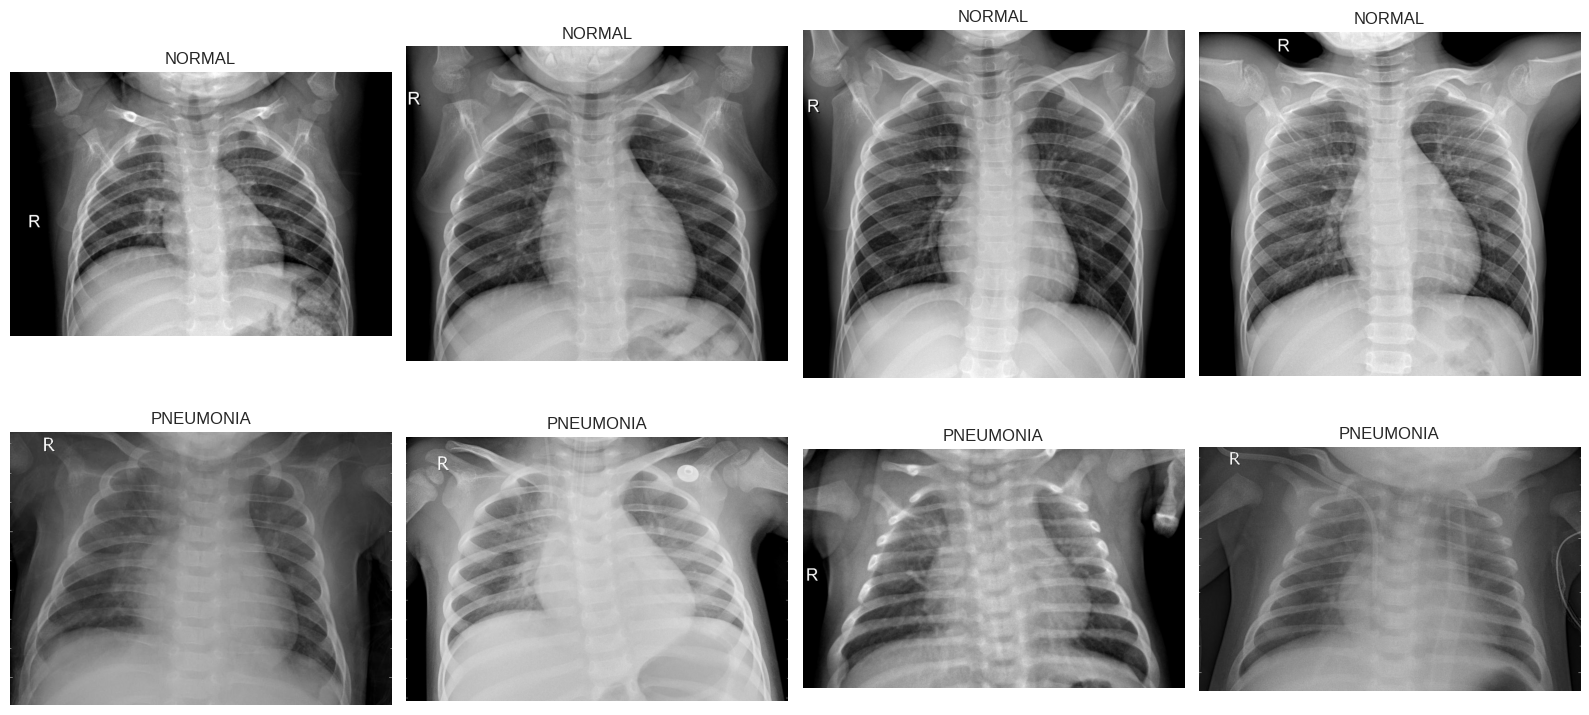

In [40]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for row, category in enumerate(['NORMAL', 'PNEUMONIA']):
    cat_path = os.path.join(dataset_path, 'train', category)
    samples = random.sample([f for f in os.listdir(cat_path) if f.endswith('.jpeg')], 4)
    for col, img_file in enumerate(samples):
        img = Image.open(os.path.join(cat_path, img_file))
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f'{category}')
plt.tight_layout()
plt.show()

# Preprocessing Pipeline
- Resize to 224×224 (ResNet50 input)
- RGB conversion
- ImageNet normalization
- Data augmentation (training only)

# 9. Methodology: Model Selection & Justification

### Architecture Choice: Why ResNet50 over VGG Inception?
We selected **ResNet50** as our backbone architecture for few reasons:
1.  **Vanishing Gradient Mitigation:** Unlike VGG, ResNet utilizes **Skip Connections**. Helps to maintain performance.
2.  **Parameter Efficiency:** Our model lighter and faster for deployment in resource-constrained medical centers.


### Pretraining Strategy: Addressing Domain Mismatch
We utilized **Transfer Learning** with weights pretrained on **ImageNet** (1.2M natural images).
* **Justification:** While ImageNet consists of non-medical images, the **early layers** of CNNs act as universal feature extractors. These low-level features are applicable to Chest X-rays.
* **Handling Data Scarcity:** Transfer learning allows us to leverage learned feature extractors and only fine-tune the high-level weights for the specific medical task.

In [41]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

print('Transforms defined')

Transforms defined


# 10. Custom Dataset Class

In [42]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpeg', '.jpg')):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

print('Dataset class defined')

Dataset class defined


# 11. Create DataLoaders

In [43]:
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

full_train = ChestXrayDataset(train_dir, train_transform)
train_idx, val_idx = train_test_split(list(range(len(full_train))), test_size=0.15, random_state=SEED, stratify=full_train.labels)

train_dataset = torch.utils.data.Subset(full_train, train_idx)
val_full = ChestXrayDataset(train_dir, val_test_transform)
val_dataset = torch.utils.data.Subset(val_full, val_idx)
test_dataset = ChestXrayDataset(test_dir, val_test_transform)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f'Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}')

def get_dist(dataset):
    if isinstance(dataset, torch.utils.data.Subset):
        labels = [dataset.dataset.labels[i] for i in dataset.indices]
    else:
        labels = dataset.labels
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

train_dist = get_dist(train_dataset)

Train: 4433, Val: 783, Test: 624


# 12. Model Initialization & Pretraining Disclosure

## A. Pretrained Model Information

**Model Name:** ResNet50 (Residual Network with 50 layers)

**Source:** torchvision.models

**Original Training Task:**
- Trained on ImageNet dataset
- 1000-class image classification
- Natural images from various categories
- 1.2 million training images

**Architecture:** 50 layers deep with residual skip connections

## B. Weight Usage Declaration

This is using pretrained weight values from ImageNet, not random initialization.

This provides:
- Transfer learning benefits
- Faster convergence
- Better performance with limited medical data
- Residual connections prevent vanishing gradients for deep feature extraction

# 13. Model Development

## Architecture and Justification

**Why ResNet50?**
1. Residual skip connections prevent vanishing gradients
2. Deep feature extraction for subtle lung opacities
3. Proven success in medical image classification
4. Computational efficiency with strong performance

**Modifications:**
- Replace final FC layer (2048 → 2 classes)
- Freeze all pretrained layers (feature extractor)
- Train only the classifier head (domain adaptation)

In [44]:
model = models.resnet50(weights='IMAGENET1K_V1')
print('ResNet50 loaded with ImageNet weights')
print(f'Original classifier: {model.fc}')

ResNet50 loaded with ImageNet weights
Original classifier: Linear(in_features=2048, out_features=1000, bias=True)


## 13. Fine-Tuning Strategy

**Transfer Learning Approach:**
1. Freeze all pretrained layers - preserve ImageNet features
2. Replace final fully connected layer for binary classification
3. Train only the new classifier head

This approach:
- Preserves robust feature extraction from ImageNet
- Enables quick domain adaptation
- Prevents overfitting on limited medical data
- Ensures computational efficiency

In [45]:
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
print(f'New classifier: {model.fc}')

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f'Trainable: {trainable:,} ({trainable/total*100:.1f}%)')
print(f'Frozen: {total-trainable:,} ({(total-trainable)/total*100:.1f}%)')

New classifier: Linear(in_features=2048, out_features=2, bias=True)
Trainable: 4,098 (0.0%)
Frozen: 23,508,032 (100.0%)


In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f'Device: {device}')

Device: cuda


## 14. Hyperparameters

Justifications:
- **LR (0.001)**: Standard learning rate for Adam with frozen backbone
- **Batch size (32)**: Balance memory if use 64 more cpu needed
- **Adam optimizer**: Adaptive learning rates, effective for CV
- **Weighted loss**: This successfully handles our imbalance in classes
- **Early Stopping (patience=3)**: Prevents overfitting by stopping when validation loss stops improving




 - **We can improve the epoch but it consumes more time and and it may lead to overfit in the model. So here we are using epoch 10 to balance this.**

In [47]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
PATIENCE = 3

print(f'LR: {LEARNING_RATE}, Epochs: {NUM_EPOCHS}, Batch: {BATCH_SIZE}, Early Stopping Patience: {PATIENCE}')

LR: 0.001, Epochs: 10, Batch: 32, Early Stopping Patience: 3


In [48]:
class_counts = [train_dist.get(0, 0), train_dist.get(1, 0)]
total_samples = sum(class_counts)
class_weights = torch.tensor([total_samples/(2*c) for c in class_counts], dtype=torch.float32).to(device)
print(f'Class weights: NORMAL={class_weights[0]:.4f}, PNEUMONIA={class_weights[1]:.4f}')

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

print('Loss and optimizer configured')

Class weights: NORMAL=1.9443, PNEUMONIA=0.6731
Loss and optimizer configured


# 15. Training Loop Implementation

## Training Process

We implement several parameters for training:
1. **Forward Pass**: Model predictions
2. **Loss Computation**: Compare predictions with labels  
3. **Backpropagation**: Compute gradients via chain rule
4. **Optimizer Update**: Adjust weights using gradients

In [49]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total

print('Training functions defined')

Training functions defined


# 16. Execute Training

In [50]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
best_model_state = None
epochs_no_improve = 0

print('Starting training with Early Stopping...')
for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 10)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
    print(f'val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'resnet50_pneumonia_best.pth')
        print("Validation loss improved. Saving model.")
    else:
        epochs_no_improve += 1
        print(f"EarlyStopping counter: {epochs_no_improve} out of {PATIENCE}")

    if epochs_no_improve >= PATIENCE:
        print("\nEarly stopping triggered.")
        break

print('\nTraining complete!')
if best_model_state:
    model.load_state_dict(best_model_state)
print(f'Best Val Loss: {best_val_loss:.4f}')

Starting training with Early Stopping...
Epoch 1/10
----------
train Loss: 0.3223 Acc: 0.8694
val Loss: 0.2274 Acc: 0.8761
Validation loss improved. Saving model.
Epoch 2/10
----------
train Loss: 0.2391 Acc: 0.9032
val Loss: 0.1763 Acc: 0.9234
Validation loss improved. Saving model.
Epoch 3/10
----------
train Loss: 0.2109 Acc: 0.9168
val Loss: 0.1654 Acc: 0.9336
Validation loss improved. Saving model.
Epoch 4/10
----------
train Loss: 0.2043 Acc: 0.9208
val Loss: 0.2045 Acc: 0.8953
EarlyStopping counter: 1 out of 3
Epoch 5/10
----------
train Loss: 0.1790 Acc: 0.9285
val Loss: 0.1988 Acc: 0.9004
EarlyStopping counter: 2 out of 3
Epoch 6/10
----------
train Loss: 0.1944 Acc: 0.9226
val Loss: 0.1622 Acc: 0.9183
Validation loss improved. Saving model.
Epoch 7/10
----------
train Loss: 0.1801 Acc: 0.9303
val Loss: 0.1863 Acc: 0.9029
EarlyStopping counter: 1 out of 3
Epoch 8/10
----------
train Loss: 0.1764 Acc: 0.9357
val Loss: 0.1443 Acc: 0.9387
Validation loss improved. Saving model.
E

# 17. Training Outputs and Logs

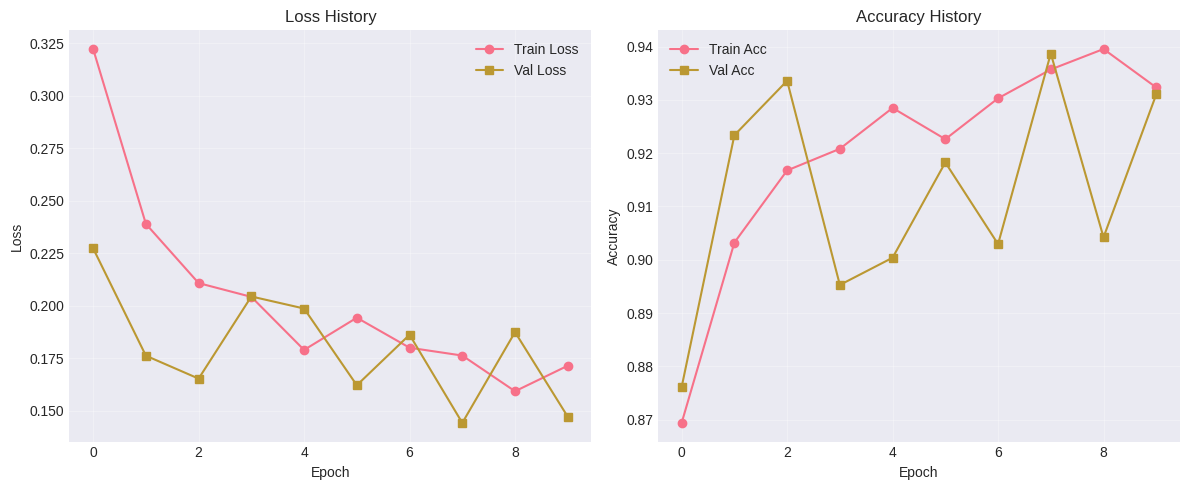

In [51]:
actual_epochs = len(history['train_loss'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc', marker='o')
plt.plot(history['val_acc'], label='Val Acc', marker='s')
plt.legend()
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 18. Performance Metrics & Evaluation

In [52]:
model.load_state_dict(torch.load('resnet50_pneumonia_best.pth', weights_only=True))
model.eval()

all_preds = []
all_labels = []
all_probs = []

print("Evaluating on Test Set...")
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Evaluating'):
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

y_pred = np.array(all_preds)
y_true = np.array(all_labels)
y_probs = np.array(all_probs)
print('Evaluation complete')

Evaluating on Test Set...


Evaluating: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]

Evaluation complete


In [53]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_probs[:, 1])


print('TEST SET METRICS')
print(f'Accuracy:  {accuracy*100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-Score:  {f1:.4f}')
print(f'AUC-ROC:   {auc:.4f}')

print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

TEST SET METRICS
Accuracy:  86.70%
Precision: 0.8434
Recall:    0.9667
F1-Score:  0.9008
AUC-ROC:   0.9428
              precision    recall  f1-score   support

      NORMAL       0.93      0.70      0.80       234
   PNEUMONIA       0.84      0.97      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.83      0.85       624
weighted avg       0.87      0.87      0.86       624



Here our model achieves a **Test Recall of 96.67%** for the Pneumonia class, identifying nearly all positive cases. This aligns with our primary clinical objective of minimizing False Negatives.

While the model exhibits a conservative bias (Recall Normal class: 0.70), resulting in some healthy scans being flagged for review (False Positives), the AUC-ROC of 0.9428 demonstrates excellent separability. This performance confirms the model's viability as a high-sensitivity and prioritizing potentially critical cases.

# 19. Confusion Matrix

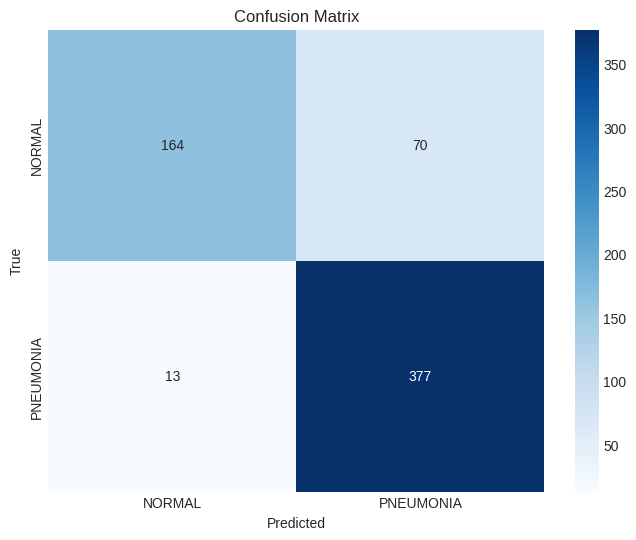

Negative cases: 164, False positives: 70, False negatives: 13, Positive cases: 377


In [55]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(f'Negative cases: {cm[0,0]}, False positives: {cm[0,1]}, False negatives: {cm[1,0]}, Positive cases: {cm[1,1]}')

# 20. ROC Curve
## ROC Curve

The ROC Curve** evaluates the model's ability to distinguish between classes across classification thresholds.

### Key Concepts:
- **True Positive Rate (TPR/Sensitivity/Recall)**: Proportion of actual pneumonia cases correctly identified
- **False Positive Rate (FPR)**: Proportion of normal cases incorrectly classified as pneumonia
- **AUC (Area Under Curve)**: Single metric summarizing overall performance (0.5 = random, 1.0 = perfect)

### Interpretation:
| AUC Score | Model Quality |
|-----------|---------------|
| 0.90–1.00 | Excellent |
| 0.80–0.90 | Good |
| 0.70–0.80 | Fair |
| 0.50–0.70 | Poor |

### Clinical Significance:
- The curve shows the trade-off between catching all pneumonia cases avoiding false alarms (low FPR)
- For medical diagnosis, we typically prefer **high sensitivity** to minimize missed pneumonia cases
- The diagonal red dashed line shows random value
- The further the blue curve bows , the better the model which indeed excellent in our model

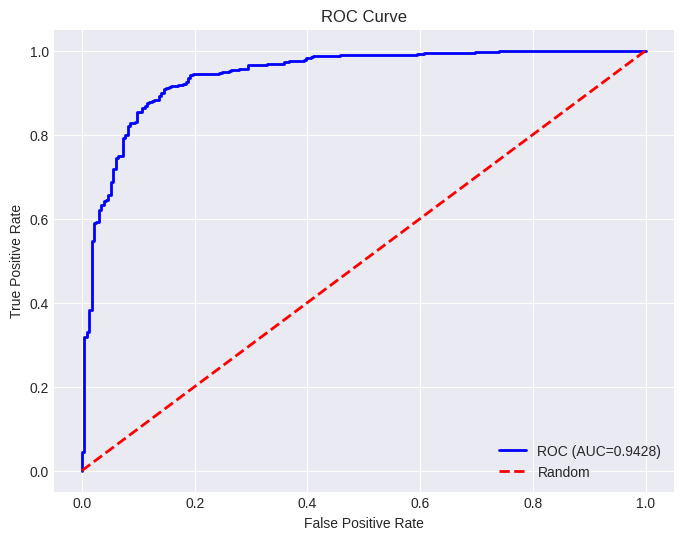

In [57]:
fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC={auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# 21. Error Analysis & Overfitting Check

In [58]:
misclassified = np.where(y_pred != y_true)[0]
print(f'Misclassified: {len(misclassified)} ({len(misclassified)/len(y_true)*100:.2f}%)')
print(f'False Positives (Normal to Pneumonia): {len(np.where((y_pred==1) & (y_true==0))[0])}')
print(f'False Negatives (Pneumonia to Normal): {len(np.where((y_pred==0) & (y_true==1))[0])} (missed pneumonia cases)')

print(f'\nOverfitting Analysis:')
print(f'Best Val Acc: {history["val_acc"][-1]*100:.2f}%')
print(f'Test Acc: {accuracy*100:.2f}%')
gap = abs(history["val_acc"][-1]*100 - accuracy*100)
print(f'Gap: {gap:.2f}%')
if gap < 5:
    print('Good generalization so minimal overfitting')
elif gap < 10:
    print('Moderate gap so some overfitting present')
else:
    print('Large gap so significant overfitting detected')

Misclassified: 83 (13.30%)
False Positives (Normal to Pneumonia): 70
False Negatives (Pneumonia to Normal): 13 (missed pneumonia cases)

Overfitting Analysis:
Best Val Acc: 93.10%
Test Acc: 86.70%
Gap: 6.40%
Moderate gap so some overfitting present


# 22. Grad-CAM Visualization

Grad-CAM (Gradient-weighted Class Activation Mapping) highlights regions the model focuses on for predictions.
This is critical for:
- Clinical Trust: Doctors can verify if the model looks at relevant lung regions
- Error Diagnosis: Understanding why misclassifications occur
- Model Validation: Ensuring the model learns meaningful features, not artifacts

In [59]:
from scipy.ndimage import zoom

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.forward_hook = self.target_layer.register_forward_hook(self.save_activation)
        self.backward_hook = self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()

        return cam.squeeze().cpu().numpy()

    def remove_hooks(self):
        self.forward_hook.remove()
        self.backward_hook.remove()

grad_cam = GradCAM(model, model.layer4)

def show_gradcam(image_tensor, label, prediction, cam_mask, class_names):
    image_np = image_tensor.cpu().numpy().transpose((1, 2, 0))
    image_np = np.array(IMAGENET_STD) * image_np + np.array(IMAGENET_MEAN)
    image_np = np.clip(image_np, 0, 1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title(f"True: {class_names[label]}, Pred: {class_names[prediction]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image_np)
    if cam_mask.shape != (224, 224):
        zoom_factors = (224 / cam_mask.shape[0], 224 / cam_mask.shape[1])
        cam_mask = zoom(cam_mask, zoom_factors, order=1)
    plt.imshow(cam_mask, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

print('Grad-CAM initialized')

Grad-CAM initialized


Visualizing True Positive Pneumonia Cases with Grad-CAM...


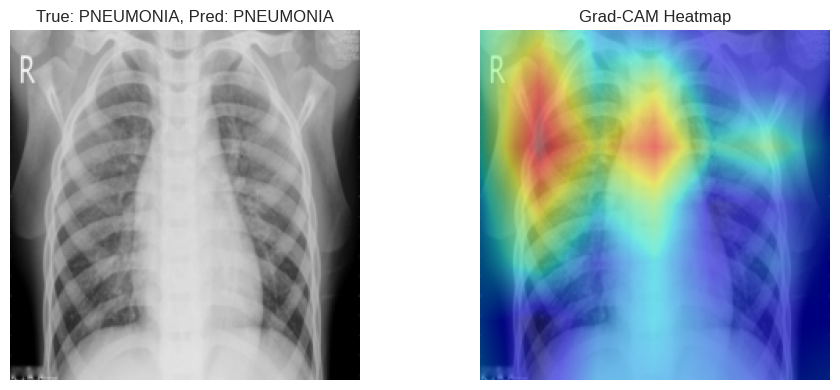

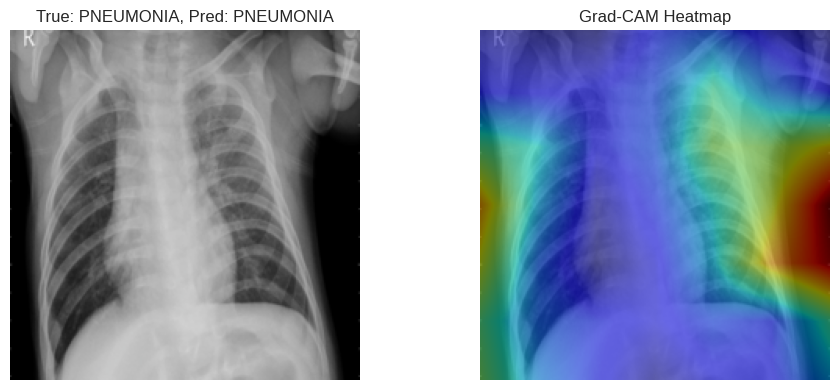

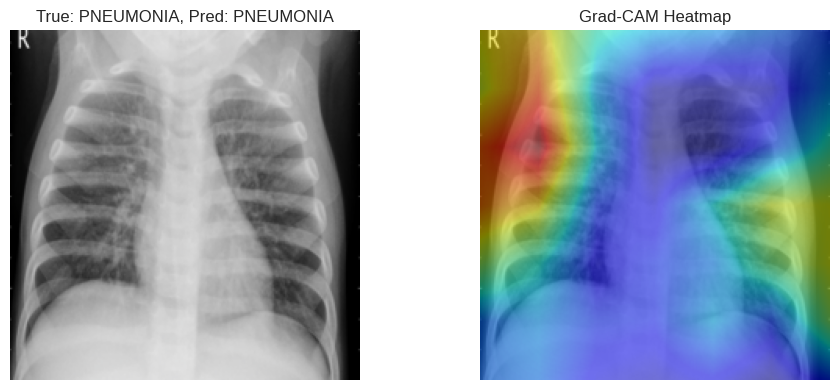

In [60]:
class_names = ['NORMAL', 'PNEUMONIA']
pneumonia_idx = class_names.index('PNEUMONIA')

print("Visualizing True Positive Pneumonia Cases with Grad-CAM...")
tp_count = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    for i in range(images.size(0)):
        if labels[i].item() == pneumonia_idx and preds[i].item() == pneumonia_idx:
            input_img = images[i].unsqueeze(0).requires_grad_(True)
            cam = grad_cam(input_img, class_idx=pneumonia_idx)
            show_gradcam(images[i], labels[i].item(), preds[i].item(), cam, class_names)
            tp_count += 1
            if tp_count >= 3:
                break
    if tp_count >= 3:
        break

if tp_count == 0:
    print("No True Positive Pneumonia cases found.")

# 23. Failure Analysis

Visualizing misclassified cases helps identify:
- Image quality issues
- Edge cases the model struggles with
- Potential dataset labeling errors

Failure Analysis (Incorrect Predictions)...

Failure Case 1


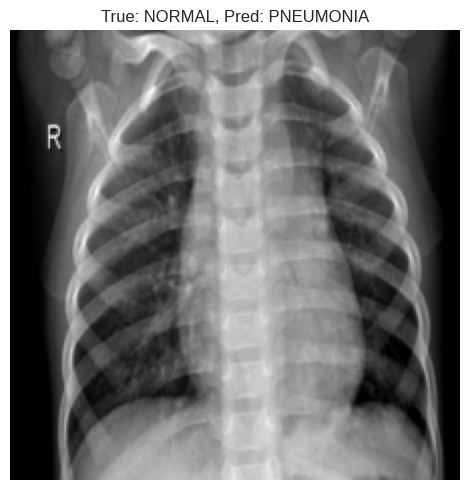


Failure Case 2


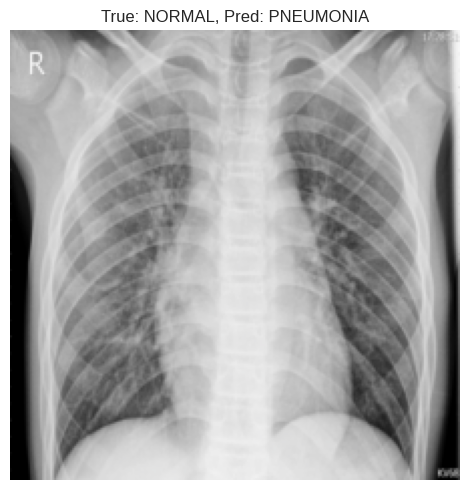


Failure Case 3


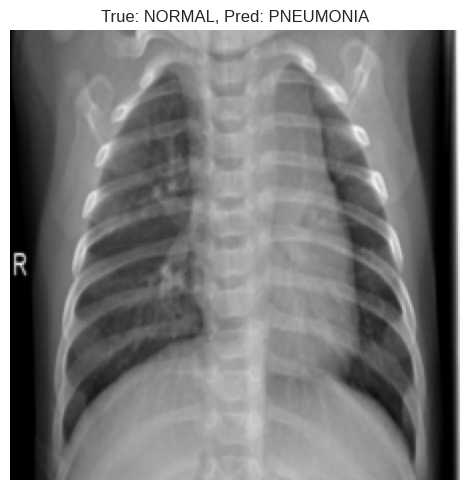


Analysis Complete


In [61]:
print("Failure Analysis (Incorrect Predictions)...")

fail_count = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    for i in range(images.size(0)):
        if labels[i].item() != preds[i].item():
            print(f"\nFailure Case {fail_count+1}")
            inp = images[i].cpu().numpy().transpose((1, 2, 0))
            inp = np.array(IMAGENET_STD) * inp + np.array(IMAGENET_MEAN)
            inp = np.clip(inp, 0, 1)

            plt.figure(figsize=(5, 5))
            plt.imshow(inp)
            plt.title(f"True: {class_names[labels[i].item()]}, Pred: {class_names[preds[i].item()]}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

            fail_count += 1
            if fail_count >= 3:
                break
    if fail_count >= 3:
        break

if fail_count == 0:
    print("No misclassifications found!")

grad_cam.remove_hooks()
print("\nAnalysis Complete")

# 24. Saving Final Model

In [62]:
torch.save({
    'model_state_dict': best_model_state,
    'model_architecture': 'ResNet50',
    'num_classes': 2,
    'best_val_loss': best_val_loss,
    'test_accuracy': accuracy,
    'test_recall': recall,
    'test_f1': f1,
    'test_auc': auc,
    'hyperparameters': {'lr': LEARNING_RATE, 'batch_size': BATCH_SIZE, 'epochs_trained': len(history['train_loss']), 'early_stopping_patience': PATIENCE}
}, 'pneumonia_resnet50_best.pth')

print('Model saved as pneumonia_resnet50_best.pth')
print(f'Test Acc: {accuracy*100:.2f}%, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}')

Model saved as pneumonia_resnet50_best.pth
Test Acc: 86.70%, Recall: 0.9667, F1: 0.9008, AUC: 0.9428


---

# 25. Summary

### Project Overview:
Automated pneumonia detection using ResNet50 pretrained on ImageNet, fine-tuned for binary classification of chest X-rays.

### Key Achievements:
- Comprehensive data preprocessing and augmentation
- Transfer Learning with ResNet50
- Early Stopping to prevent overfitting
- Grad-CAM explainability for clinical interpretability
- Multiple performance metrics
- Failure analysis with misclassification visualization
- Reproducibility via fixed random seed (42)

### Addressing Overfitting:
- Early stopping monitors validation loss
- Frozen backbone prevents memorization
- Clean validation set for honest evaluation





# 26. Demo Inference Dashboard

A standalone inference module that loads the trained model and runs prediction with Grad-CAM visualization on any chest X-ray image. This can be used for deployment or clinical demonstration.

   PNEUMONIA DETECTION - DEMO INFERENCE
Model loaded from checkpoint
  Test Accuracy: 86.70%
  Test Recall: 0.9667
  Test AUC: 0.9428
Running on: cuda

Running inference on: person1676_virus_2892.jpeg


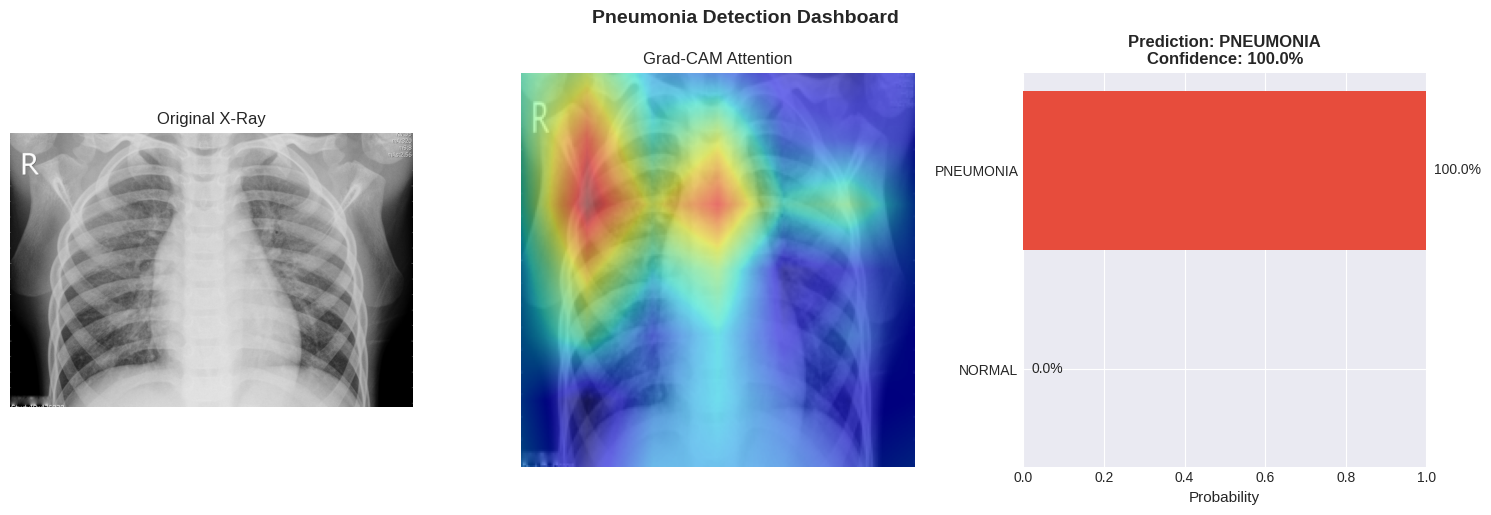

HIGH CONFIDENCE PNEUMONIA DETECTION - Recommend radiologist review

Results: {'prediction': 'PNEUMONIA', 'confidence': 0.9998540878295898, 'probabilities': {'NORMAL': 0.00014583670417778194, 'PNEUMONIA': 0.9998540878295898}}


In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
import os

MODEL_PATH = 'pneumonia_resnet50_best.pth'
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def load_model(model_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 2)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)

    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded from checkpoint")
        print(f"  Test Accuracy: {checkpoint.get('test_accuracy', 'N/A'):.2%}")
        print(f"  Test Recall: {checkpoint.get('test_recall', 'N/A'):.4f}")
        print(f"  Test AUC: {checkpoint.get('test_auc', 'N/A'):.4f}")
    else:
        model.load_state_dict(checkpoint)
        print("Model state dict loaded directly")

    model = model.to(device)
    model.eval()
    return model, device

class GradCAMInference:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        self.forward_hook = self.target_layer.register_forward_hook(
            lambda m, i, o: setattr(self, 'activations', o.detach())
        )
        self.backward_hook = self.target_layer.register_full_backward_hook(
            lambda m, gi, go: setattr(self, 'gradients', go[0].detach())
        )

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot)

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam.squeeze().cpu().numpy()

    def cleanup(self):
        self.forward_hook.remove()
        self.backward_hook.remove()

def predict_xray(image_path, model, device, show_gradcam=True):
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])

    original_img = Image.open(image_path).convert('RGB')
    input_tensor = transform(original_img).unsqueeze(0).to(device)
    input_tensor.requires_grad_(True)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        confidence, pred_idx = torch.max(probs, dim=1)

    prediction = CLASS_NAMES[pred_idx.item()]
    conf_score = confidence.item()

    result = {
        'prediction': prediction,
        'confidence': conf_score,
        'probabilities': {
            'NORMAL': probs[0, 0].item(),
            'PNEUMONIA': probs[0, 1].item()
        }
    }

    if show_gradcam:
        input_tensor = transform(original_img).unsqueeze(0).to(device)
        input_tensor.requires_grad_(True)

        grad_cam = GradCAMInference(model, model.layer4)
        cam = grad_cam.generate(input_tensor, class_idx=pred_idx.item())
        grad_cam.cleanup()

        if cam.shape != (IMG_SIZE, IMG_SIZE):
            cam = zoom(cam, (IMG_SIZE / cam.shape[0], IMG_SIZE / cam.shape[1]), order=1)

        img_display = input_tensor.squeeze().cpu().detach().numpy().transpose((1, 2, 0))
        img_display = np.array(IMAGENET_STD) * img_display + np.array(IMAGENET_MEAN)
        img_display = np.clip(img_display, 0, 1)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(original_img, cmap='gray')
        axes[0].set_title('Original X-Ray', fontsize=12)
        axes[0].axis('off')

        axes[1].imshow(img_display)
        axes[1].imshow(cam, cmap='jet', alpha=0.5)
        axes[1].set_title('Grad-CAM Attention', fontsize=12)
        axes[1].axis('off')

        colors = ['#2ecc71' if prediction == 'NORMAL' else '#e74c3c',
                  '#e74c3c' if prediction == 'NORMAL' else '#2ecc71']
        bars = axes[2].barh(CLASS_NAMES, [result['probabilities']['NORMAL'],
                                           result['probabilities']['PNEUMONIA']],
                            color=colors[::-1])
        axes[2].set_xlim(0, 1)
        axes[2].set_xlabel('Probability', fontsize=11)
        axes[2].set_title(f'Prediction: {prediction}\nConfidence: {conf_score:.1%}',
                          fontsize=12, fontweight='bold')

        for bar, val in zip(bars, [result['probabilities']['NORMAL'],
                                    result['probabilities']['PNEUMONIA']]):
            axes[2].text(val + 0.02, bar.get_y() + bar.get_height()/2,
                        f'{val:.1%}', va='center', fontsize=10)

        plt.tight_layout()
        plt.suptitle('Pneumonia Detection Dashboard', fontsize=14, fontweight='bold', y=1.02)
        plt.show()

        if prediction == 'PNEUMONIA' and conf_score > 0.7:
            print("HIGH CONFIDENCE PNEUMONIA DETECTION - Recommend radiologist review")
        elif prediction == 'PNEUMONIA':
            print("Possible pneumonia detected - Further evaluation recommended")
        else:
            print("No pneumonia indicators detected")

    return result

print("   PNEUMONIA DETECTION - DEMO INFERENCE")


model, device = load_model(MODEL_PATH)
print(f"Running on: {device}\n")

sample_image = None
test_paths = [
    os.path.join(dataset_path, 'test', 'PNEUMONIA'),
    os.path.join(dataset_path, 'test', 'NORMAL')
]

for test_path in test_paths:
    if os.path.exists(test_path):
        images = [f for f in os.listdir(test_path) if f.endswith(('.jpeg', '.jpg', '.png'))]
        if images:
            sample_image = os.path.join(test_path, images[0])
            break

if sample_image:
    print(f"Running inference on: {os.path.basename(sample_image)}")
    result = predict_xray(sample_image, model, device, show_gradcam=True)
    print(f"\nResults: {result}")
else:
    print("No sample image found. Use predict_xray('path/to/image.jpg', model, device)")
    print("\nExample usage:")
    print("  result = predict_xray('chest_xray.jpg', model, device)")
    print("  print(result['prediction'], result['confidence'])")

---
**Team GMora - BioFusion Hackathon 2026**